# LISA Response Function Tutorial
This notebook serves as a tutorial and demonstration of how to use the `GWResponse` package to simulate the response of the LISA detector to gravitational waves from compact binary coalescences. 

The goal is to help users understand and visualize the key features of the detector response — including the transfer functions and strain signals — using realistic waveforms. Throughout the notebook, we focus on the dominant (2,2) mode and assume standard approximations for the LISA constellation geometry.


## Transfer Function and Detector Response Validation

This section explores and validates different aspects of the frequency-domain response of LISA, as implemented in `GWResponse`. All results shown here use the dominant (2,2) mode of the IMRPhenomD waveform.

---

### 1. Phase Derivative and Merger Identification

We begin by computing the derivative of the phase with respect to frequency, \(-d\phi/df\), which, according to the Stationary Phase Approximation, gives an estimate of the time when each frequency becomes dominant in the signal. The frequency at which this derivative reaches a minimum corresponds to the moment of merger.

The plot on the left confirms that the minimum of \(-d\phi/df\) aligns with the peak of the waveform, validating the implementation of the phase evolution.




In [1]:
#Event input
import os
import sys
# Compute the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add custom module folder to system path
sys.path.insert(0, project_root)

import jax.numpy as np
import gwresponse.utils as gw

SF_mass1 = 3.e5 # source-frame mass 1
SF_mass2 = 1.e5 # source-frame mass 2
M_total = SF_mass1 + SF_mass2  # in solar masses
q = 3  # mass ratio
eta = q / (1 + q)**2  # η = q/(1+q)^2
Mc = M_total * eta**(3/5)
z = 4.
D = 36594.3/1000 # en Gpc
event_ex = {'Mc':np.array([Mc])*(1.+z), 
            'dL':np.array([D]), 
            'theta':np.array([2.38001159]), 
            'phi':np.array([3.54542016]),
            'iota':np.array([0.24698124]), 
            'psi':np.array([0.14995378]),
            'tcoal':np.array([0.10534095]),
            'eta':np.array([eta]), 
            'Phicoal':np.array([5.77110428]), 
            'chi1z':np.array([0.03651518]), 
            'chi2z':np.array([0.01077526]), 
            'Lambda1':np.array([1349.94067482]), 
            'Lambda2':np.array([2.69614788])
           }

gw.validate_event_parameters(event_ex)

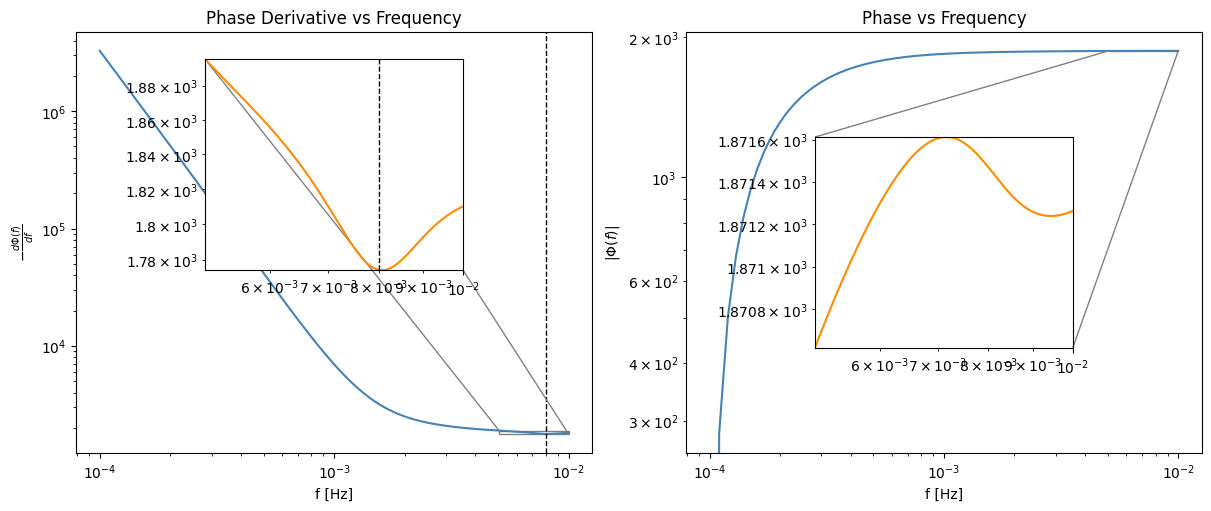

In [2]:
# Phase and its derivative Validation
import os
import sys
# Compute the absolute path to the project root (assumes notebook is in /notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add custom module folder to system path
sys.path.insert(0, project_root)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import jax.numpy as np  # Asegúrate de tener numpy importado

from gwresponse import IMRPhenomD_JAX


f = np.linspace(1e-4, 1e-2, 1000)

# --------------------------------------------------------------
# Compute phase and its derivative (without frequency cut)
# --------------------------------------------------------------
phenomD = IMRPhenomD_JAX(apply_fcut=False)
phase, dphase = IMRPhenomD_JAX(apply_fcut=False).Phi(f, **event_ex)

# Get joining frequency for Merger-Ringdown from PhenomD model
phenomD.Phi(f, **event_ex)
MfMRD = phenomD.PHI_fjoin_MRD  #reduced frequency (Mf)
# Gravitational constant times solar mass over c³ (seconds)
GMsun_over_c3 = 4.925491025543576e-6
fMRD = MfMRD/(event_ex['Mc'] / event_ex['eta']**(3./5.) * GMsun_over_c3)


# --------------------------------------------------------------
# Plot result
# --------------------------------------------------------------

# Create a figure with 2 columns (subplots side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# ------------------ Phase derivative ------------------
ax1.plot(f, -dphase, color='steelblue')
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_title("Phase Derivative vs Frequency")
ax1.set_xlabel("f [Hz]")
ax1.set_ylabel(r"$-\frac{d\Phi(f)}{df}$")
ax1.axvline(x=fMRD, color='black', linestyle='--', linewidth=1)  # Merger-Ringdown transition

# Zoom-in on the phase derivative
axins1 = inset_axes(ax1, width="50%", height="50%", loc='upper center', borderpad=2)
axins1.plot(f[500:], -dphase[500:], color='darkorange')
axins1.set_yscale("log")
axins1.set_xscale("log")
axins1.set_xlim(f[500], f[-1])
axins1.set_ylim(np.min(-dphase[500:]), np.max(-dphase[500:]))
axins1.axvline(x=fMRD, color='black', linestyle='--', linewidth=1)
mark_inset(ax1, axins1, loc1=2, loc2=4, fc="none", ec="gray", lw=1)

# ------------------ Phase ------------------
ax2.plot(f, -phase, color='steelblue')
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_title("Phase vs Frequency")
ax2.set_xlabel("f [Hz]")
ax2.set_ylabel(r"$|\Phi(f)|$")


# Zoom-in on the phase
axins2 = inset_axes(ax2, width="50%", height="50%", loc='center', borderpad=2)
axins2.plot(f[500:], np.abs(phase[500:]), color='darkorange')
axins2.set_yscale("log")
axins2.set_xscale("log")
axins2.set_xlim(f[500], f[-1])
axins2.set_ylim(np.min(np.abs(phase[500:])), np.max(np.abs(phase[500:])))
mark_inset(ax2, axins2, loc1=2, loc2=4, fc="none", ec="gray", lw=1)

plt.show()


---

### 2. Signal-Dependent Time: \( t^{(2,2)}_f - t_\text{merger} \)

Using the derivative of the phase, we reconstruct the time \( t_f \) at which each frequency \( f \) is emitted. Subtracting the time of merger yields a map between frequency and "time before coalescence".

This relation is crucial to interpret frequency-dependent quantities (like the orbital delay or Doppler phase) in a physically meaningful time context. The plot shows this time evolution on a logarithmic scale, annotated with specific values for reference (42 h, 2.5 h, 7 min).


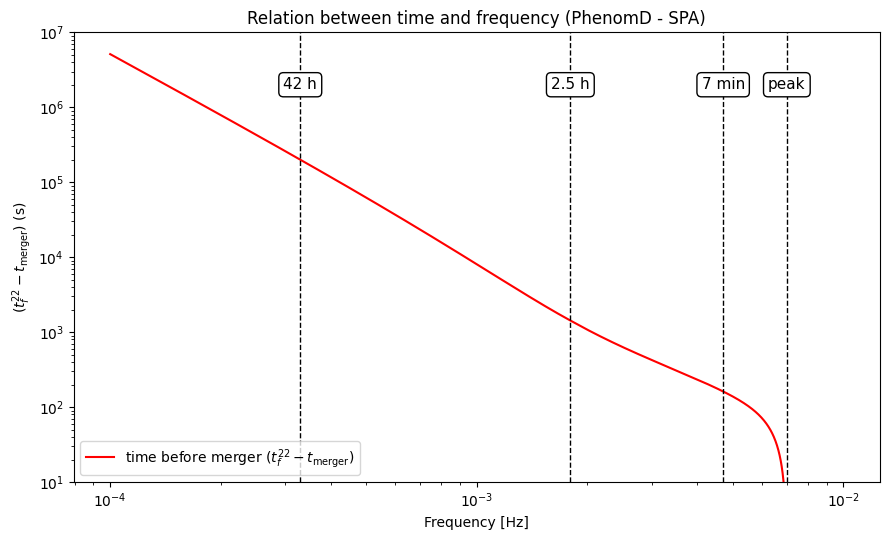

In [3]:
# Time–Frequency Relation Validation 
# -----------------------------------------------------------------------------
# Time–Frequency Relation Validation 
# This notebook cell computes the SPA-based time–frequency mapping:
#     tf = -1/(2π) dΦ/df
# It uses the PhenomD waveform model without applying f_cut.
# -----------------------------------------------------------------------------

import os
import sys
# Compute the absolute path to the project root (assumes notebook is in /notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add custom module folder to system path
sys.path.insert(0, project_root)


from gwresponse import IMRPhenomD_JAX

# --------------------------------------------------------------
# Frequency array covering [1e-4 Hz, 1e-2 Hz]
# This corresponds to LISA band for massive binaries
# --------------------------------------------------------------
f = np.linspace(1e-4, 1e-2, 1000)

# --------------------------------------------------------------
# Compute phase and its derivative (without frequency cut)
# --------------------------------------------------------------
phenomD = IMRPhenomD_JAX(apply_fcut=False)
phase, dphase = IMRPhenomD_JAX(apply_fcut=False).Phi(f, **event_ex)

# --------------------------------------------------------------
# Compute effective time tf using SPA: tf = -1/(2π) dΦ/df
# --------------------------------------------------------------
# Convert Mf → Hz using detector-frame chirp mass
GMsun_over_c3 = 4.925491025543576e-6  # seconds
M_det_frame = event_ex['Mc'] / event_ex['eta']**(3./5.)* GMsun_over_c3
tf = -dphase / (2 * np.pi) * M_det_frame.item()

# -------------------------------
# Get peak frequency in Hz (from reduced Mf)
# -------------------------------
phenomD.Ampl(f, **event_ex)  # Needed to load fpeak internally
Mf_peak = phenomD.fpeak

# Convert Mf → Hz using detector-frame chirp mass
GMsun_over_c3 = 4.925491025543576e-6  # seconds
M_det_frame = event_ex['Mc'] / event_ex['eta']**(3./5.)
f_peak = (Mf_peak / (M_det_frame * GMsun_over_c3)).item()

# --------------------------------------------------------------
# Set t_merger = tf at the highest frequency (end of waveform)
# Then compute time before merger
# --------------------------------------------------------------
t_merger = tf[-1]
time_before_merger = tf - t_merger

# --------------------------------------------------------------
# Plot result: should look similar to Figure 3 (top curve)
# --------------------------------------------------------------
plt.figure(figsize=(9, 5.5))
plt.plot(f, time_before_merger, label=r"time before merger $(t_f^{22} - t_{\mathrm{merger}})$", color='red')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$(t_f^{22} - t_{\mathrm{merger}})$ (s)")
plt.title("Relation between time and frequency (PhenomD - SPA)")
plt.ylim(1e1, 1e7)

# -----------------------------------------------------------------------------
# Add vertical lines as in Figure 3: [42h, 2.5h, 7min] and f_peak
# Frequencies estimated visually from paper
# -----------------------------------------------------------------------------
milestones = {
    "42 h": 3.3e-4,
    "2.5 h": 1.8e-3,
    "7 min": 4.7e-3,
    "peak": f_peak
}

for label, fx in milestones.items():
    plt.axvline(x=fx, color='black', linestyle='--', linewidth=1)
    plt.text(fx, 2e6, label, ha='center', va='center', fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.legend()
plt.tight_layout()
plt.show()


---

### 3. Doppler Phase and TDI Transfer Functions

Here we show two types of response features:

- Orbital Doppler Phase \( \Delta\Phi_R(f) \):  
  This phase shift accounts for the fact that LISA is moving around the Sun while the gravitational wave arrives. The Doppler phase depends on both frequency and the relative direction of the source. It introduces oscillations at low frequencies due to the orbital motion of LISA during long signals.

- TDI Transfer Functions:  
  The response of LISA is projected into three orthogonal combinations of the spacecraft links: A, E, and T channels. These transfer functions modulate the waveform amplitude and phase depending on the source direction and frequency. The A and E channels are sensitive to the GW signal over most of the band, while the T channel is suppressed at low frequencies (by design, to cancel laser noise). For visualization purposes, the following transfer functions are shown after factoring out the Doppler phase.


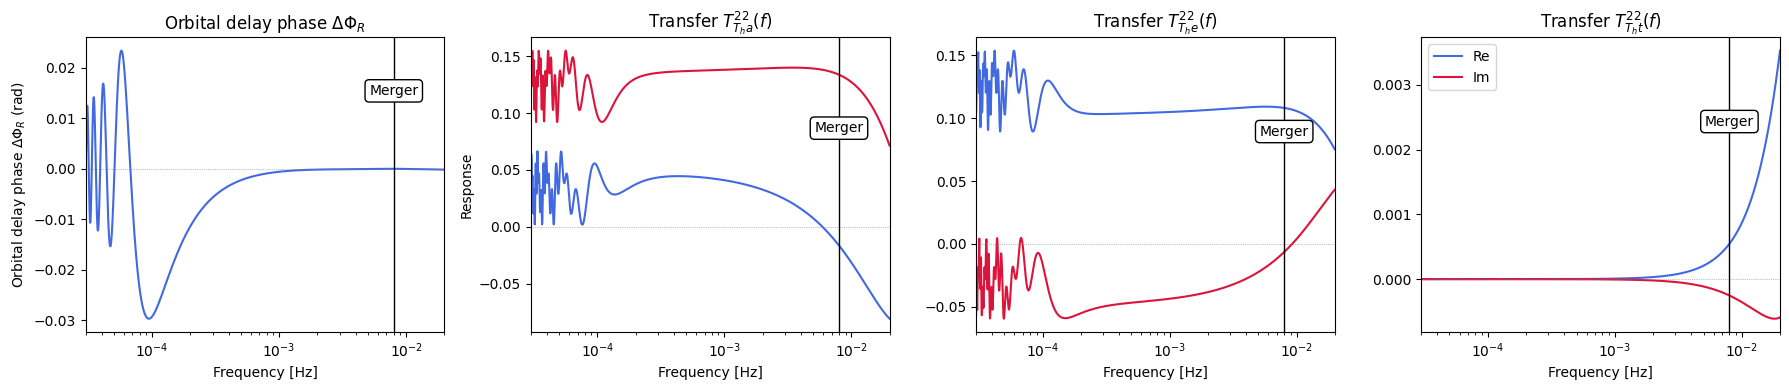

In [2]:
# Transfer Functions Validation
# ------------------------------------------------------------
# Compute and plot LISA transfer functions and Doppler phase
# for a given sky location and source parameters.
# Includes visualization of orbital delay phase and TDI channels.
# ----------------------------------------------------------
import os
import sys
import jax
# Compute the absolute path to the project root (assumes notebook is in /notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add custom module folder to system path
sys.path.insert(0, project_root)

import jax.numpy as np
import matplotlib.pyplot as plt

from gwresponse import LISA_response
from gwresponse import IMRPhenomD_JAX

# ------------------------------------------------------------
# LISA source sky location and polarization parameters
# ------------------------------------------------------------
key = jax.random.PRNGKey(592439)  # seed for reproducibility
# Generate 2 random angles
key, *subkeys = jax.random.split(key, 3)
angles = [jax.random.uniform(k, minval=-2*np.pi, maxval=2*np.pi) for k in subkeys]
# Assign to your variables
lambd, beta = angles


# ------------------------------------------------------------
# Frequency array covering full LISA-sensitive band
# ------------------------------------------------------------
f = np.linspace(3e-5, 2e-2, 100000)  # Hz

# ------------------------------------------------------------
# Compute GW phase and merger frequency from PhenomD model
# ------------------------------------------------------------
phenomD = IMRPhenomD_JAX(apply_fcut=False)
phenomD.Phi(f, **event_ex)
MfMRD = phenomD.PHI_fjoin_MRD  # Merger-ringdown joining frequency (reduced frequency)

# Convert to physical frequency [Hz]
GMsun_over_c3 = 4.925491025543576e-6  # seconds
fMRD = (MfMRD / (event_ex['Mc'] / event_ex['eta']**(3. / 5.) * GMsun_over_c3)).item()

# ------------------------------------------------------------
# Compute LISA response and Doppler phase (ΔΦ_R)
# ------------------------------------------------------------
response = LISA_response(f, lambd, beta, **event_ex)
T_ha, T_he, T_ht = response.TDI_transfer(f, reduced_scale = True, rescaled = True)
phi_R, delay_phase = response.doppler_phase(f, return_delay=True)

# Factor out Doppler phase from TDI transfer functions
doppler = np.exp(-1j * phi_R)
T_ha *= doppler
T_he *= doppler
T_ht *= doppler

# ------------------------------------------------------------
# Set labels and milestone frequency markers (e.g., merger)
# ------------------------------------------------------------
labels = ['T_ha', 'T_he', 'T_ht']
TDIs = [T_ha, T_he, T_ht]
milestones = {
    "Merger": fMRD
}

# ------------------------------------------------------------
# Plot orbital delay phase ΔΦ_R and transfer functions
# ------------------------------------------------------------
plt.figure(figsize=(18, 4))

# ---------------- Panel 1: Orbital Delay Phase ----------------
ax = plt.subplot(1, 4, 1)
ax.semilogx(f, delay_phase, color='royalblue')
ax.axhline(0, color='gray', lw=0.5, linestyle=':')
ax.set_xlim(3e-5, 2e-2)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Orbital delay phase $\\Delta \\Phi_R$ (rad)")
ax.set_title("Orbital delay phase $\\Delta \\Phi_R$")

# Mark merger frequency
for label, fx in milestones.items():
    ax.axvline(x=fx, color='black', linestyle='-', linewidth=1)
    ax.text(fx, 0.6 * max(delay_phase), label, ha='center', va='bottom', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# ---------------- Panels 2–4: Transfer Functions ----------------
for i, T in enumerate(TDIs):
    ax = plt.subplot(1, 4, i + 2)

    # Plot real and imaginary parts of the transfer function
    ax.semilogx(f, np.real(T), 'royalblue', label='Re')
    ax.semilogx(f, np.imag(T), 'crimson', label='Im')

    # Aesthetics
    ax.axhline(0, color='gray', lw=0.5, linestyle=':')
    ax.set_xlim(3e-5, 2e-2)
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title(f'Transfer $T^{{22}}_{{{labels[i]}}}(f)$')

    if i == 0:
        ax.set_ylabel("Response")
    if i == 2:
        ax.legend(loc='upper left')

    # Mark merger frequency
    y_displacement = [0.5, 0.54,0.65]
    for label, fx in milestones.items():
        ymax = np.max(np.abs(T))
        ax.axvline(x=fx, color='black', linestyle='-', linewidth=1)
        ax.text(fx, y_displacement[i] * ymax, label, ha='center', va='bottom', fontsize=10,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

---

### 4. Characteristic Strain Signal

Finally, we compute the strain signals observed in the A, E, and T channels after applying the transfer functions to the input waveform.

These plots show the **characteristic strain** \( \tilde{h}_c(f) = 2f \tilde{h}(f) \) for each channel. As expected:
- A and E show similar structure and amplitude,
- The T channel is strongly suppressed at low frequencies, consistent with its noise-cancellation role.

These strain curves illustrate the combined effect of the source waveform, the LISA response, and the frequency-dependent sensitivity of each channel.


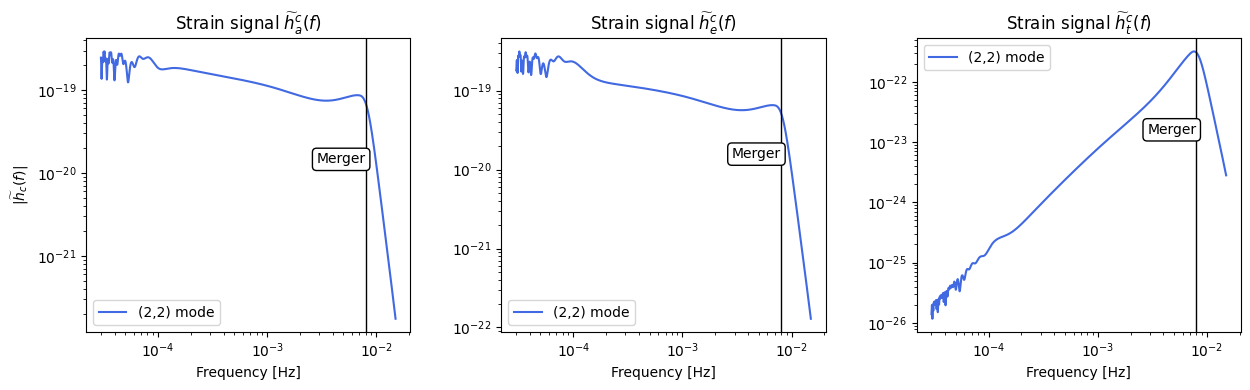

In [17]:
# Strain Signal Plot
# ---------------------------------------------------------------------------
# Compute and Plot Strain Signal for LISA TDI Channels: a, e, t
# This script computes the waveform strain in each LISA TDI observable
# using the IMRPhenomD model (without frequency cut) and the full LISA response.
# It multiplies each channel by 2f to get the characteristic strain hc(f) = 2f·h̃(f)
# ---------------------------------------------------------------------------
import os
import sys
# Compute the absolute path to the project root (assumes notebook is in /notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add custom module folder to system path
sys.path.insert(0, project_root)

import jax.numpy as np
import matplotlib.pyplot as plt

from gwresponse import LISA_response
from gwresponse import IMRPhenomD_JAX

# ------------------------------------------------------------
# LISA source sky location and polarization parameters
# ------------------------------------------------------------
lambd = 2.275           # Ecliptic longitude [rad]
beta = -1.376           # Ecliptic latitude [rad]
theta = np.pi / 3       # Inclination of angular momentum [rad]
phi = -1.249            # Phase of source [rad]
psi = 1.635             # Polarization angle [rad]
kappa = 0               # Phase shift in constellation orbit



# --------------------------------------------------------------
# Frequency array (LISA band)
# --------------------------------------------------------------
f = np.linspace(3e-5, 1.5e-2, 100000)  # Frequencies in Hz

# --------------------------------------------------------------
# Compute phase (needed only to extract f_MRD)
# --------------------------------------------------------------
phenomD = IMRPhenomD_JAX(apply_fcut=False)
phenomD.Phi(f, **event_ex)
Mf_MRD = phenomD.PHI_fjoin_MRD  # Merger-ringdown transition (in Mf)

# Convert Mf_MRD to physical frequency (Hz)
GMsun_over_c3 = 4.925491025543576e-6  # seconds
f_MRD = (Mf_MRD / (event_ex['Mc'] / event_ex['eta']**(3./5.) * GMsun_over_c3)).item()

# --------------------------------------------------------------
# Compute LISA response in TDI channels: A, E, T
# and multiply each by 2f to obtain characteristic strain
# --------------------------------------------------------------
response = LISA_response(f, lambd, beta, **event_ex)
ha, he, ht = response.TDI(f, reduced_scale= True)  # Raw frequency-domain strain in A, E, T
ha = 2 * f * ha  # h_c(f) = 2f × h̃(f)
he = 2 * f * he
ht = 2 * f * ht

# --------------------------------------------------------------
# Plot each TDI channel's characteristic strain
# --------------------------------------------------------------
labels = ['a', 'e', 't']  # TDI labels
TDIs = [ha, he, ht]
milestones = { "Merger": f_MRD }  # Mark merger frequency on the plot

plt.figure(figsize=(16, 4))

for i, h in enumerate(TDIs):
    ax = plt.subplot(1, 4, i + 2)

    # Plot |h_c(f)| (magnitude of characteristic strain)
    ax.loglog(f, np.abs(h), 'royalblue', label='(2,2) mode')

    # Formatting
    ax.axhline(0, color='gray', lw=0.5, linestyle=':')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_title(fr'Strain signal $\widetilde{{h}}^{{c}}_{{{labels[i]}}}(f)$')
    
    if i == 0:
        ax.set_ylabel(r'$|\widetilde{h}_c(f)|$')

    # Legend positioning
    if i in [0, 1]:
        ax.legend(loc='lower left')
    else:
        ax.legend(loc='upper left')

    # Mark merger frequency
    for label, fx in milestones.items():
        ax.axvline(x=fx, color='black', linestyle='-', linewidth=1)
        ymax = np.max(np.abs(h))
        ax.text(fx, 0.05 * ymax, label, ha='right', va='center', fontsize=10,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()